In [1]:
import numpy as np
import pandas as pd

# plot
import glob
import cv2
import matplotlib.pyplot as plt

# tf
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import splitfolders

## Data Collecting

Dataset diambil dari website kaggle.

### Tujuan PA

Membuat sebuah model yang dapat mengenali jenis dari serangga dengan menggunakan algoritma CNN.

Batasan:
  - Model ini hanya dapat mengenali:
    - Kupu - Kupu, 
    - Capung, 
    - Nyamuk, 
    - Belalang,
    - dan Kumbang.

### Deskripsi Dataset

Dataset ini berupa gambar dari 5 serangga berbeda.

### Jumlah Dataset

- Kupu - Kupu: 899
- Capung: 1036
- Nyamuk: 690
- Belalang: 960
- Kumbang: 864

Total: 4449 data

### Data Train & Validation

URL path ke direktori dataset.
berupa direktori dataset.
dan dataset output (dataset yang akan dihasilkan ketika melakukan split folder). 

In [2]:
url = 'insect'
url_split = 'dataset_output'

In [3]:
splitfolders.ratio(url, output=url_split, seed=42, ratio=(0.7,0.2,0.1), group_prefix=None)

Disini saya menggunakan Image data generator dan batch size sebanyak 128
untuk validation, saya menggunakan 20% data.
Kemudian untuk subset training dan validation, target size nya adalah 120.

ambil path dari folder masing - masing output

In [4]:
train = 'dataset_output/train'
val = 'dataset_output/val'
test = 'dataset_output/test'

In [5]:
batch_size = 128

train_image_generator = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.1,
    fill_mode='nearest',
) #data preprocessing

train = train_image_generator.flow_from_directory(
    train, 
    target_size=(120,120),
    batch_size=batch_size, 
    color_mode="grayscale"
)

test = train_image_generator.flow_from_directory(
    test, 
    target_size=(120,120),
    batch_size=batch_size,
    color_mode="grayscale"
)

val = train_image_generator.flow_from_directory(
    val, 
    target_size=(120,120),
    batch_size=batch_size,
    color_mode="grayscale"
)

Found 3112 images belonging to 5 classes.
Found 449 images belonging to 5 classes.
Found 888 images belonging to 5 classes.


### Visualisasi Dataset

Augmentasi

In [8]:
data_img = train_image_generator.flow_from_directory(
    url, #path gambar disimpan
    target_size= (150,150),
    batch_size= 8,
    shuffle = True,
    # class_mode = 'categorical',
    # save_to_dir = 'augmented',
    # save_prefix = 'aug',
    # save_format= "jpg"
)

Found 4449 images belonging to 5 classes.


Visualisasi

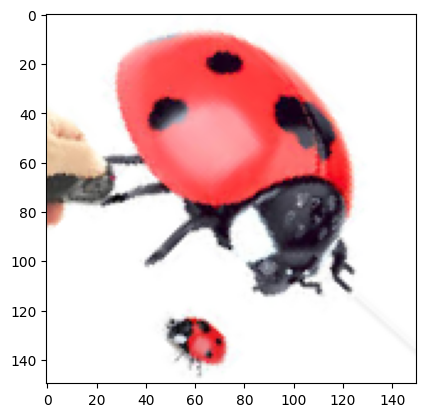

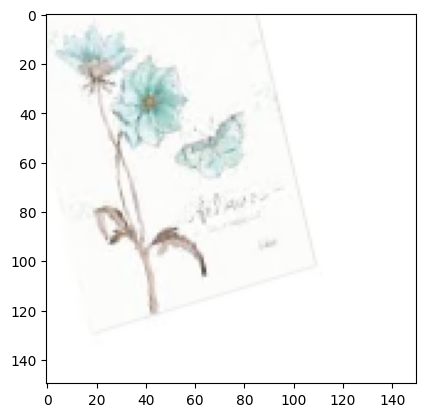

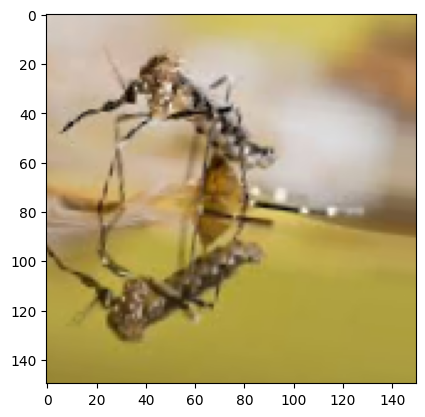

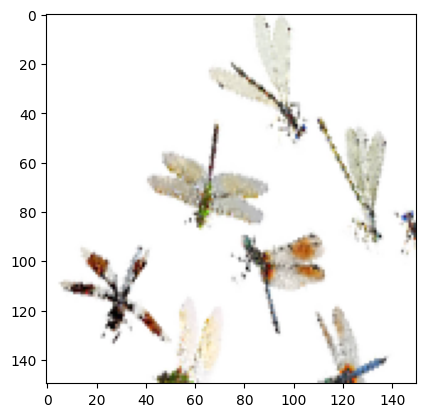

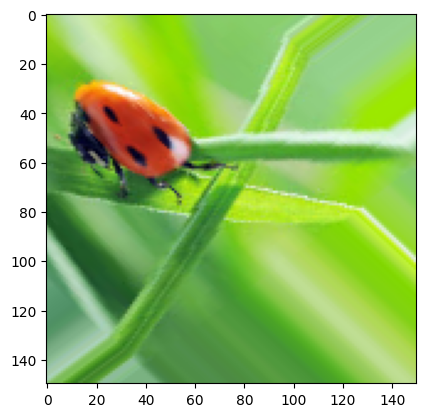

In [9]:
# Buat folder dlu disesuaikan sama nama di save_to_dir
for i in range(5):
  img,label = data_img.next()
  plt.imshow(img[0])
  # plt.axis('off')
  plt.show()

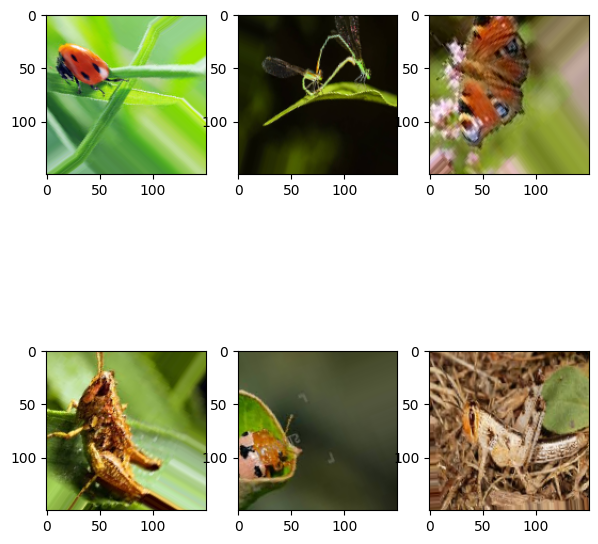

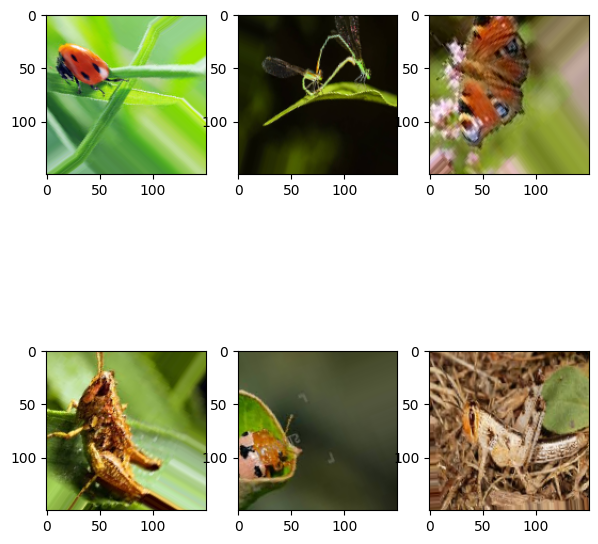

In [19]:
rows = 2
cols = 3
# fig = plt.figure(figsize=(7,8))
# for j in range (0, rows*cols):
#     fig.add_subplot(rows, cols, j+1)
#     plt.imshow(img[j])

for i in range(0, len(img), rows*cols):
    fig = plt.figure(figsize=(7,8))
    for j in range (0, rows*cols):
        fig.add_subplot(rows, cols, j+1)
        plt.imshow(img[j])
        # plt.imshow(img[i+j])
    plt.show()

In [20]:
image, label = train.next()

label_name = ['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']

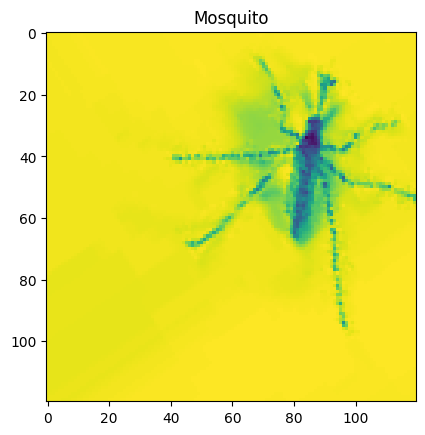

In [21]:
plt.title(label_name[tf.argmax(label[2])])
plt.imshow(image[2])
plt.show()

# Model 

Pada syntax di atas model dibentuk dengan suatu layer convo 2 dimensi dari size 120 x 120 pixels dimana fungsi aktivasinya adalah. Terdapat dua pembuatan layer convo, sehingga dilanjutkan dengan pembuatan layer max pooling dan pembuatan layer dropout. Karena ini adalah pelatihan deep learning maka perlu pelatihan lagi dengan membuat lagi layer untuk pelatihan. Kemudian dilanjutkan dengan layer flatten dan layer dense sampai dengan proses kompilasi.



In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, 
        (3,3), 
        activation='relu',
        input_shape=(120, 120, 1), #parameter 3 untuk warna, kalau grayscale nilainya 1 kalau berwarna 3 
        ),
    tf.keras.layers.MaxPooling2D(2, 2), # untuk mengecilkan feature map

    tf.keras.layers.Conv2D(
      32,
      (3,3), 
      activation='relu',
      ),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(
        32, 
        (3,3), 
        activation='relu', 
        ),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(
      128,
      (3,3), 
      activation='relu',
    ),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.3), # drop neuron secara random

    tf.keras.layers.Flatten(), # untuk jadikan 1dimensi

    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax'), #multiclass pakai softmax
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# adam untuk mengurangi overfitting


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0

epoch dibuat sebanyak 30

In [24]:
# coba pakai callback custom misalnya: stop kalau accuracy train > 95%, dan earlystopping
history = model.fit(train, validation_data=val, epochs=30)

Epoch 1/30
25/25 [==============================] - 33s 1s/step - loss: 1.6002 - accuracy: 0.2233 - val_loss: 1.5787 - val_accuracy: 0.2905
Epoch 2/30
25/25 [==============================] - 19s 754ms/step - loss: 1.5514 - accuracy: 0.2940 - val_loss: 1.5275 - val_accuracy: 0.2939
Epoch 3/30
25/25 [==============================] - 19s 765ms/step - loss: 1.5352 - accuracy: 0.3120 - val_loss: 1.4902 - val_accuracy: 0.3682
Epoch 4/30
25/25 [==============================] - 19s 740ms/step - loss: 1.4893 - accuracy: 0.3377 - val_loss: 1.4173 - val_accuracy: 0.3919
Epoch 5/30
25/25 [==============================] - 19s 741ms/step - loss: 1.4513 - accuracy: 0.3740 - val_loss: 1.4065 - val_accuracy: 0.4133
Epoch 6/30
25/25 [==============================] - 19s 746ms/step - loss: 1.4418 - accuracy: 0.3644 - val_loss: 1.3772 - val_accuracy: 0.4054
Epoch 7/30
25/25 [==============================] - 19s 775ms/step - loss: 1.4171 - accuracy: 0.3782 - val_loss: 1.3651 - val_accuracy: 0.4291
Ep

In [25]:
model.evaluate(test)

4/4 [==============================] - 3s 695ms/step - loss: 1.1771 - accuracy: 0.5167


[1.1771091222763062, 0.5167037844657898]

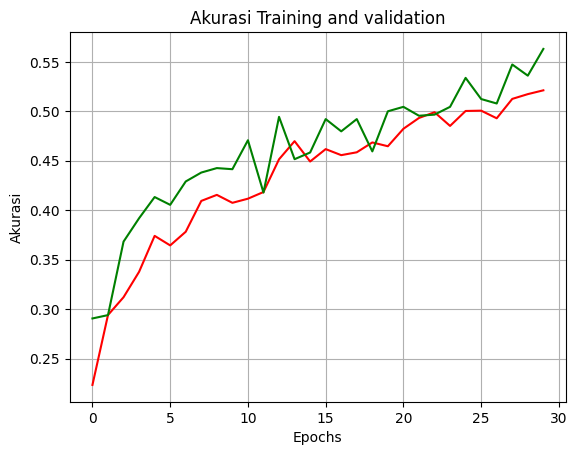

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training')
plt.plot(epochs, val_acc, 'g', label='Akurasi Validation')

plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.title('Akurasi Training and validation')
plt.grid(axis='both')

plt.show() 

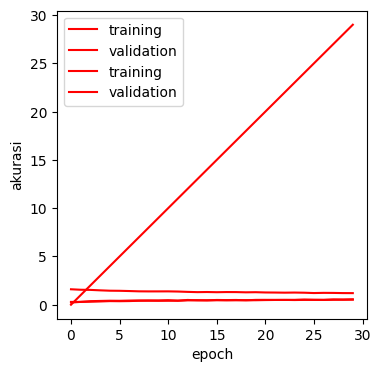

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(1, figsize=(4,4))
plt.plot(epochs,  acc, c='r', label='training')
plt.plot(epochs,  val_acc, c='r', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('akurasi')

plt.figure(1, figsize=(4,4))
plt.plot(epochs,  loss, c='r', label='training')
plt.plot(epochs,  epochs, c='r', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('akurasi')

plt.show()

# plt.plot(epochs, acc, 'r', label='Akurasi Training')
# plt.plot(epochs, val_acc, 'g', label='Akurasi Validation')

# plt.xlabel('Epochs')
# plt.ylabel('Akurasi')
# plt.title('Akurasi Training and validation')
# plt.grid(axis='both')

# plt.show() 